# Machine Learning Models

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gamma, poisson, norm, t, ttest_ind
import pymc3 as pm
from numpy.random import seed
from scipy import stats

In [2]:
df = pd.read_csv('Data/data.csv')
X = pd.read_csv('Data/X.csv')
Y1 = pd.read_csv('Data/Y1.csv')
Y2 = pd.read_csv('Data/Y2.csv')
columns = X.columns
a, b = X.shape
  # ac is in TensorFlow format
Tdata = np.c_[np.ones((a, 1)), X]

### MACHINE LEARNING

#### Note: tilt and slope are equally correlated, excluding either does not appear to impact score.

In [3]:
# Report lists many scores to be used during parameter tuning
def report_scores(data_Y, predicted):
    print("accuracy",metrics.accuracy_score(data_Y, predicted))
    print("f1 score macro",metrics.f1_score(data_Y, predicted, average='macro')) 
    print("f1 score micro",metrics.f1_score(data_Y, predicted, average='micro')) 
    print("precision score",metrics.precision_score(data_Y, predicted, average='macro')) 
    print("recall score",metrics.recall_score(data_Y, predicted, average='macro')) 
    print("hamming_loss",metrics.hamming_loss(data_Y, predicted))
    print("classification_report", metrics.classification_report(data_Y, predicted))
    print("jaccard_similarity_score", metrics.jaccard_score(data_Y, predicted))
    print("log_loss", metrics.log_loss(data_Y, predicted))
    print("zero_one_loss", metrics.zero_one_loss(data_Y, predicted))
    print("AUC&ROC",metrics.roc_auc_score(data_Y, predicted))
    print("matthews_corrcoef", metrics.matthews_corrcoef(data_Y, predicted))

### Logistic Regression

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

# Split the data into a training and test set.
xtrain, xtest, ytrain, ytest = train_test_split(X, Y1,random_state=5)

ytrain = np.ravel(ytrain) # optimize the shape of y

clf = LogisticRegression(solver='lbfgs')
clf.fit(xtrain, ytrain)


# Print the accuracy from the testing data.
print("Initial accuracy score for Logistic Regression: ", accuracy_score(clf.predict(xtest), ytest))

Initial accuracy score for Logistic Regression:  0.8717948717948718


In [6]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

#### Performing a KFold split of 5 results in same accuracy

In [9]:
def cv_score(clf, x, y, score_func=accuracy_score):
    result = 0
    nfold = 6
    for train, test in KFold(nfold).split(x): # split data into train/test groups, 5 times
        clf.fit(x, y) # fit
        result += score_func(clf.predict(x[test]), y[test]) # evaluate score function on held-out data
    return result / nfold # average

In [10]:
clf = LogisticRegression(solver='lbfgs')
score = cv_score(clf, xtrain, ytrain)
print(score)
print("Initial accuracy score for Logistic Regression: ", accuracy_score(clf.predict(xtest), ytest))

KeyError: "None of [Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,\n            17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,\n            34, 35, 36, 37, 38],\n           dtype='int64')] are in the [columns]"

#### Performing a GridSearch to optimize the C parameter...

In [46]:
from sklearn.model_selection import GridSearchCV
def cv_optimize(clf, parameters, xtrain, ytrain, n_folds=5):
    gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds)
    gs.fit(xtrain, ytrain)
    print("BEST PARAMS", gs.best_params_)
    best = gs.best_estimator_
    return best

In [47]:
parameters = {"C": [0.0001, 0.001, 0.1, 0.5, 1, 10]}
print(cv_optimize(clf, parameters, xtrain, ytrain, n_folds=5))

BEST PARAMS {'C': 0.1}
LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


In [167]:
# Run LogisticRegression with optimized C parameter
clfl2=LogisticRegression(solver='lbfgs',C=0.1)
ytest = np.ravel(ytest)
clfl2.fit(xtest, ytest)
ypred2=clfl2.predict(xtest)
accuracy_score(ypred2, ytest)
report_scores(data_Y, ypred2)

accuracy 0.8717948717948718
f1 score macro 0.8627726952850105
f1 score micro 0.8717948717948718
precision score 0.8685714285714285
recall score 0.8583333333333334
hamming_loss 0.1282051282051282
classification_report               precision    recall  f1-score   support

       False       0.86      0.80      0.83        30
        True       0.88      0.92      0.90        48

    accuracy                           0.87        78
   macro avg       0.87      0.86      0.86        78
weighted avg       0.87      0.87      0.87        78

jaccard_similarity_score 0.8148148148148148
log_loss 4.428109763252411
zero_one_loss 0.1282051282051282
AUC&ROC 0.8583333333333333
matthews_corrcoef 0.7268326590665243


### Gaussian Naive Bayes

In [113]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(xtrain,ytrain)
y_model = model.predict(xtest)
print("Accuracy for Gaussian Naive Bayes: ", accuracy_score(y_model, ytest))

Accuracy for Gaussian Naive Bayes:  0.7564102564102564


In [114]:
from sklearn.preprocessing import StandardScaler
ss_xtest = StandardScaler().fit_transform(xtest)
ss_xtrain = StandardScaler().fit_transform(xtrain)

### KNeighborsClassifier

#### After turning n_neighbors to 10, accuracy results are the same as Logistic Regression

In [204]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(xtrain,ytrain)
y_pred = knn.predict(xtest)
print("Accuracy for K Nearest Neighbors: ", accuracy_score(ytest, y_pred))

Accuracy for K Nearest Neighbors:  0.8717948717948718


In [227]:
model = KNeighborsClassifier()
model.fit(xtrain,ytrain)
KNeighborsClassifier(algorithm='auto', leaf_size=10, metric='euclidean', metric_params=None, n_jobs=1, n_neighbors=10, p=1, weights='uniform')

kn_pred = model.predict(xtest)

In [228]:
report_scores(data_Y, kn_pred)

accuracy 0.8076923076923077
f1 score macro 0.7955617683033374
f1 score micro 0.8076923076923077
precision score 0.7976776917663617
recall score 0.79375
hamming_loss 0.19230769230769232
classification_report               precision    recall  f1-score   support

       False       0.76      0.73      0.75        30
        True       0.84      0.85      0.85        48

    accuracy                           0.81        78
   macro avg       0.80      0.79      0.80        78
weighted avg       0.81      0.81      0.81        78

jaccard_similarity_score 0.7321428571428571
log_loss 6.642154393629512
zero_one_loss 0.1923076923076923
AUC&ROC 0.7937500000000001
matthews_corrcoef 0.5914146496540943


In [265]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(max_depth=5, random_state=1)
rfc.fit(xtrain, ytrain)
ypred = rfc.predict(xtest)
print(metrics.accuracy_score(ytest, rfc.predict(xtest)))


0.8333333333333334


In [271]:
def randomforest(xtrain, ytrain, xtest, scores):
    rfc = RandomForestClassifier(n_estimators=10)
    rfc.fit(xtrain, ytrain)
    ypred = rfc.predict(xtest)
    scores.append(metrics.accuracy_score(ytest, rfc.predict(xtest)))

In [272]:
trials = range(1,100)
accuracyscores = []
for i in trials:
    randomforest(xtrain, ytrain, xtest, accuracyscores)
 #   accuracyscores.append(scores)

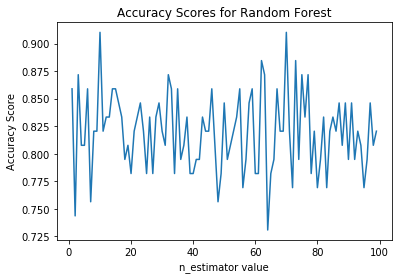

In [276]:
plt.plot(range(1,100),accuracyscores)
plt.xlabel('n_estimator value')
plt.ylabel('Accuracy Score')
plt.title('Accuracy Scores for Random Forest')
plt.show()

In [283]:
rfc = RandomForestClassifier(n_estimators=12)
rfc.fit(xtrain, ytrain)
ypred = rfc.predict(xtest)
print(metrics.accuracy_score(ytest, rfc.predict(xtest)))

0.9358974358974359


In [331]:
report_scores(ytest, ypred)

accuracy 0.9358974358974359
f1 score macro 0.9308878256246678
f1 score micro 0.9358974358974359
precision score 0.9422657952069716
recall score 0.9229166666666666
hamming_loss 0.0641025641025641
classification_report               precision    recall  f1-score   support

       False       0.96      0.87      0.91        30
        True       0.92      0.98      0.95        48

    accuracy                           0.94        78
   macro avg       0.94      0.92      0.93        78
weighted avg       0.94      0.94      0.94        78

jaccard_similarity_score 0.9038461538461539
log_loss 2.214065132875311
zero_one_loss 0.0641025641025641
AUC&ROC 0.9229166666666666
matthews_corrcoef 0.8649660707556456
